<a href="https://colab.research.google.com/github/MateoJaksic/Analiza-populacijskih-podataka/blob/main/analizapopulacijskihpodataka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza populacijskih podataka

Projekt se bavi analizom populacijskih podataka država u Europi. Analizira se broj stanovnika u razdoblju od 2012. do 2023. godine te se radi predikcija za naredne godine.

Podaci su preuzeti s [Eurostata](https://ec.europa.eu/eurostat/databrowser/view/tps00001/default/table?lang=en&category=t_demo.t_demo_pop).

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.optim as optim

Dohvaćanje podataka.

In [69]:
df = pd.read_csv('https://raw.githubusercontent.com/MateoJaksic/Analiza-populacijskih-podataka/main/podaci.csv?token=GHSAT0AAAAAACIKYZDS2IJVV2V4P6WFQAX4ZN5FX4A', delimiter=",")

df = df.rename(columns={'geo': 'country_code'})
df = df.rename(columns={'TIME_PERIOD': 'year'})
df = df.rename(columns={'OBS_VALUE': 'population'})

In [53]:
df_code = pd.read_csv('https://raw.githubusercontent.com/MateoJaksic/Analiza-populacijskih-podataka/main/drzave.csv?token=GHSAT0AAAAAACIKYZDTJBYSL3KRZJ44RTT2ZN5FK6Q', delimiter=",")

Za početak ćemo izračunati populaciju Europske Unije (EU) za 2023. godinu. To ćemo postići zbrajanjem populacija 27 država članica EU.

Prvo dohvaćamo listu država koje su članice EU.

In [74]:
clanice_eu = list(df_code[df_code['eu'] == '+'].country_code)

Nakon toga dohvaćamo podatke o njihovoj populaciji za 2023. godinu.

In [151]:
populacija = {}
eu_populacija = 0

for drzava in clanice_eu:
  eu_populacija += int(df[(df['country_code'] == drzava) & (df['year'] == 2023)].population)
  populacija[drzava] = round(float(int(df[(df['country_code'] == drzava) & (df['year'] == 2023)].population) / 1000000), 2)

eu_populacija = round(float(eu_populacija / 1000000), 2)

Izračunamo udio populacije države u populaciji EU za 2023. godinu.

In [159]:
udio_populacije_eu = {}
for drzava in clanice_eu:
  udio_populacije_eu[drzava] = str(round(float(populacija[drzava] / eu_populacija) * 100, 2)) + "%"

Tablični prikaz podataka o populaciji za članice EU u 2023. godini u milijunima. Tablica sadrži populaciju države i udio populacije te države u populaciji EU.

In [160]:
podaci = {
    'drzava': list(df_code[df_code['eu'] == '+'].country),
    'populacija': list(populacija.values()),
    'udio': list(udio_populacije_eu.values())
}

df_populacija = pd.DataFrame(podaci)
df_populacija = df_populacija.set_index('drzava')
df_populacija = tabulate(df_populacija, headers=['Država', "Populacija", "Udio"], tablefmt='fancy_grid')
print(df_populacija)

╒═════════════╤══════════════╤════════╕
│ Država      │   Populacija │ Udio   │
╞═════════════╪══════════════╪════════╡
│ Austria     │         9.1  │ 2.03%  │
├─────────────┼──────────────┼────────┤
│ Belgium     │        11.75 │ 2.62%  │
├─────────────┼──────────────┼────────┤
│ Bulgaria    │         6.45 │ 1.44%  │
├─────────────┼──────────────┼────────┤
│ Cyprus      │         0.92 │ 0.21%  │
├─────────────┼──────────────┼────────┤
│ Czechia     │        10.83 │ 2.42%  │
├─────────────┼──────────────┼────────┤
│ Germany     │        84.36 │ 18.81% │
├─────────────┼──────────────┼────────┤
│ Denmark     │         5.93 │ 1.32%  │
├─────────────┼──────────────┼────────┤
│ Estonia     │         1.37 │ 0.31%  │
├─────────────┼──────────────┼────────┤
│ Greece      │        10.39 │ 2.32%  │
├─────────────┼──────────────┼────────┤
│ Spain       │        48.06 │ 10.72% │
├─────────────┼──────────────┼────────┤
│ Finland     │         5.56 │ 1.24%  │
├─────────────┼──────────────┼────────┤


Tablični prikaz podatka o populaciji EU u 2023. godini u milijunima.

In [149]:
podaci = [[eu_populacija]]

eu_populacija_tablica = tabulate(podaci, headers=['Europska unija'], tablefmt='fancy_grid')
print(eu_populacija_tablica)

╒══════════════════╕
│   Europska unija │
╞══════════════════╡
│           448.39 │
╘══════════════════╛


Kreiramo funkciju koja će raditi ispis podataka o populaciji za pojedini državu.

In [206]:
def prikaz_podataka_za_drzavu(country_code):
  godine_drzava = list(df[df['country_code'] == country_code].year)
  populacija_drzava = list(round((df[df['country_code'] == country_code].population)/1000000, 2))

  podaci = {
      'godina': godine_drzava,
      'populacija': populacija_drzava
  }

  df_populacija_drzava = pd.DataFrame(podaci)
  df_populacija_drzava = df_populacija_drzava.set_index('godina')
  df_populacija_drzava = tabulate(df_populacija_drzava, headers=['Godina', 'Populacija'], tablefmt='fancy_grid')
  print(df_populacija_drzava)

  graf_populacija_drzava_x = podaci['godina']
  graf_populacija_drzava_y = podaci['populacija']

  drzava = list(df_code[df_code['country_code'] == country_code].country)

  plt.figure(1, [15, 3])
  plt.plot(graf_populacija_drzava_x, graf_populacija_drzava_y, color='blue')
  plt.grid(True, alpha=0.5)
  plt.xlabel('Godina')
  plt.ylabel('Populacija (u milijunima)')
  plt.title(f'{drzava[0]} - populacija (2012. - 2023.)')
  plt.show()

Prikaz podataka populacije od 2012. do 2023. godine za Hrvatsku u milijunima.

╒══════════╤══════════════╕
│   Godina │   Populacija │
╞══════════╪══════════════╡
│     2012 │         4.28 │
├──────────┼──────────────┤
│     2013 │         4.26 │
├──────────┼──────────────┤
│     2014 │         4.25 │
├──────────┼──────────────┤
│     2015 │         4.23 │
├──────────┼──────────────┤
│     2016 │         4.19 │
├──────────┼──────────────┤
│     2017 │         4.15 │
├──────────┼──────────────┤
│     2018 │         4.11 │
├──────────┼──────────────┤
│     2019 │         4.08 │
├──────────┼──────────────┤
│     2020 │         4.06 │
├──────────┼──────────────┤
│     2021 │         4.04 │
├──────────┼──────────────┤
│     2022 │         3.86 │
├──────────┼──────────────┤
│     2023 │         3.85 │
╘══════════╧══════════════╛


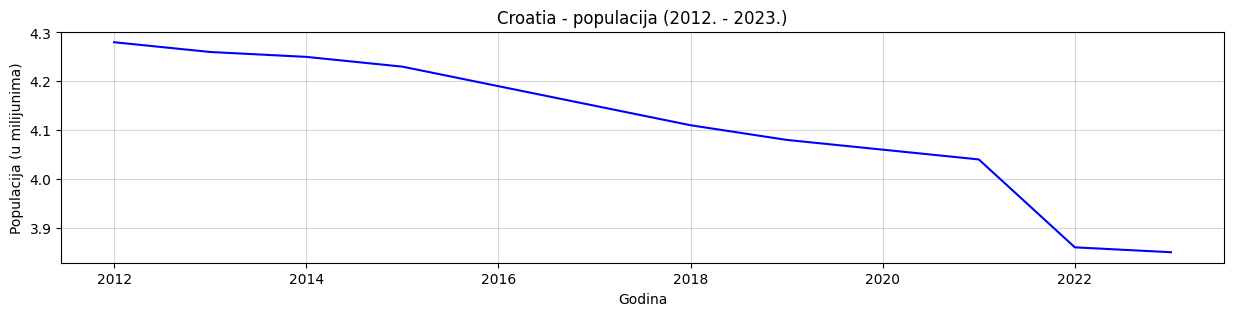

In [207]:
prikaz_podataka_za_drzavu('HR')

Prikaz podataka populacije od 2012. do 2023. godine za Njemačku u milijunima.

╒══════════╤══════════════╕
│   Godina │   Populacija │
╞══════════╪══════════════╡
│     2012 │        80.33 │
├──────────┼──────────────┤
│     2013 │        80.52 │
├──────────┼──────────────┤
│     2014 │        80.77 │
├──────────┼──────────────┤
│     2015 │        81.2  │
├──────────┼──────────────┤
│     2016 │        82.18 │
├──────────┼──────────────┤
│     2017 │        82.52 │
├──────────┼──────────────┤
│     2018 │        82.79 │
├──────────┼──────────────┤
│     2019 │        83.02 │
├──────────┼──────────────┤
│     2020 │        83.17 │
├──────────┼──────────────┤
│     2021 │        83.16 │
├──────────┼──────────────┤
│     2022 │        83.24 │
├──────────┼──────────────┤
│     2023 │        84.36 │
╘══════════╧══════════════╛


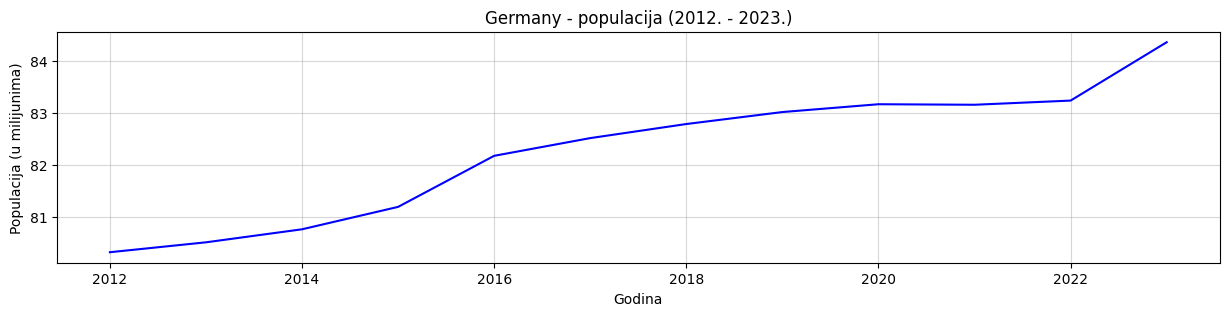

In [210]:
prikaz_podataka_za_drzavu('DE')

Prikaz podataka populacije od 2012. do 2023. godine za Irsku u milijunima.

╒══════════╤══════════════╕
│   Godina │   Populacija │
╞══════════╪══════════════╡
│     2012 │         4.59 │
├──────────┼──────────────┤
│     2013 │         4.61 │
├──────────┼──────────────┤
│     2014 │         4.64 │
├──────────┼──────────────┤
│     2015 │         4.68 │
├──────────┼──────────────┤
│     2016 │         4.73 │
├──────────┼──────────────┤
│     2017 │         4.78 │
├──────────┼──────────────┤
│     2018 │         4.83 │
├──────────┼──────────────┤
│     2019 │         4.9  │
├──────────┼──────────────┤
│     2020 │         4.96 │
├──────────┼──────────────┤
│     2021 │         5.01 │
├──────────┼──────────────┤
│     2022 │         5.06 │
├──────────┼──────────────┤
│     2023 │         5.19 │
╘══════════╧══════════════╛


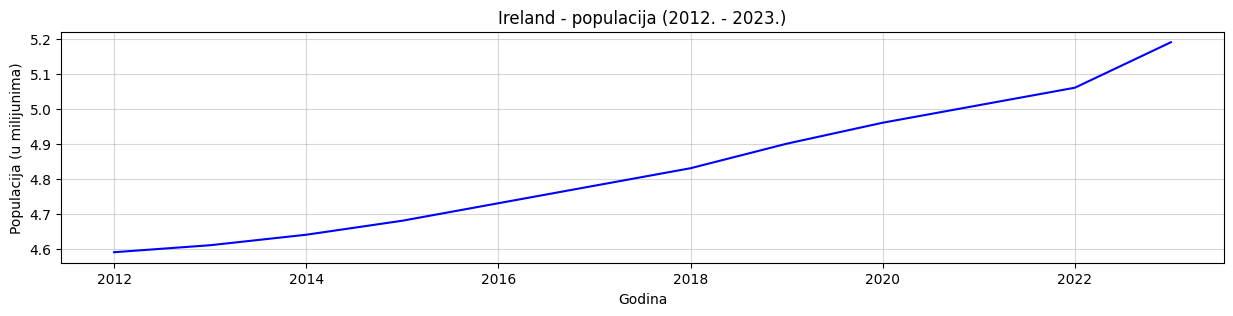

In [209]:
prikaz_podataka_za_drzavu('IE')

Prikaz podataka populacije od 2012. do 2023. godine za Latviju u milijunima.

╒══════════╤══════════════╕
│   Godina │   Populacija │
╞══════════╪══════════════╡
│     2012 │         2.04 │
├──────────┼──────────────┤
│     2013 │         2.02 │
├──────────┼──────────────┤
│     2014 │         2    │
├──────────┼──────────────┤
│     2015 │         1.99 │
├──────────┼──────────────┤
│     2016 │         1.97 │
├──────────┼──────────────┤
│     2017 │         1.95 │
├──────────┼──────────────┤
│     2018 │         1.93 │
├──────────┼──────────────┤
│     2019 │         1.92 │
├──────────┼──────────────┤
│     2020 │         1.91 │
├──────────┼──────────────┤
│     2021 │         1.89 │
├──────────┼──────────────┤
│     2022 │         1.88 │
├──────────┼──────────────┤
│     2023 │         1.88 │
╘══════════╧══════════════╛


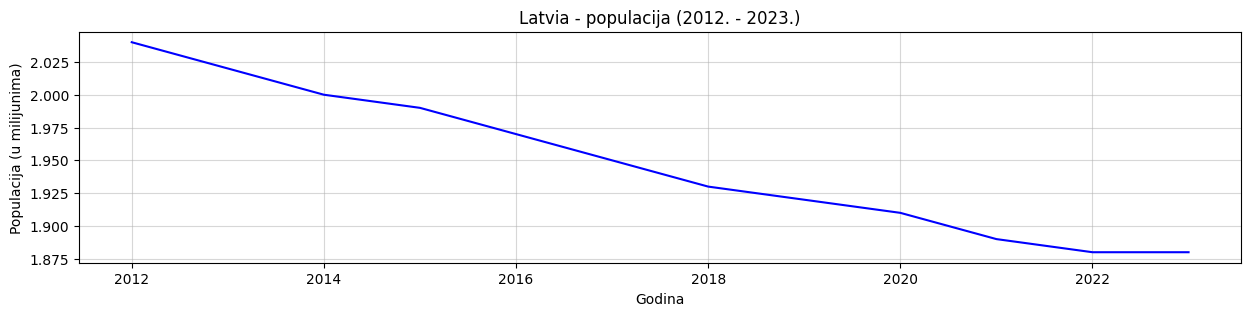

In [212]:
prikaz_podataka_za_drzavu('LV')